In [1]:
!pip install mamba-ssm

In [2]:
!pip install pydub
!pip install librosa

In [3]:
!pip install thop

In [4]:
!pip install tensorflow_datasets

In [5]:
import torch
torch.cuda.is_available()

True

In [165]:
# Get the total memory of the GPU
total_memory = torch.cuda.get_device_properties(0).total_memory

# Calculate the fraction that corresponds to 1GB
fraction = 1 * 1024**3 / total_memory

# Set the memory fraction for the current process
torch.cuda.set_per_process_memory_fraction(fraction, device=0)
print(f"Memory fraction set to {fraction}")
# Print fraction in GB
print(f"Memory fraction in GB: {fraction * total_memory / 1024**3}")

Memory fraction set to 0.022458079576498518
Memory fraction in GB: 1.0


In [45]:
import tensorflow_datasets as tfds
# Load data
version = 3 # just 3 is available
ds, info = tfds.load(f'speech_commands:0.0.{version}', with_info=True, as_supervised=True)
train_ds = ds['train']
val_ds = ds['validation']


In [46]:
import numpy as np
import tensorflow as tf
# maintain seed for repructablity
np.seed = 42
tf.random.set_seed(42)
torch.manual_seed(0)

In [47]:
label_names = info.features['label'].names
print(label_names)

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']


In [48]:
print('Batch Shape:', train_ds.element_spec[0].shape)
print('Label Shape:', train_ds.element_spec[1].shape)

Batch Shape: (None,)
Label Shape: ()


In [49]:
print(train_ds.element_spec)

(TensorSpec(shape=(None,), dtype=tf.int16, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [50]:
import torch 
from torch.utils.data import DataLoader, Dataset
import numpy as np
from librosa.feature import mfcc

# Define the dataset adapter:
class TFDatasetAdapter(Dataset):
    def __init__(self, tf_dataset, fixed_length, n_mfcc, n_fft, hop_length, n_mels, augmentations=None):
        self.tf_dataset = tf_dataset
        self.data = list(tf_dataset)
        self.fixed_length = fixed_length
        self.n_mfcc = n_mfcc
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.augmentations = augmentations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        audio, label = self.data[idx]
        audio = audio.numpy()

        # Ensure the audio tensor has the correct shape (1D array)
        if audio.ndim > 1:
            audio = np.squeeze(audio)
            
        # Apply augmentations if any
        if self.augmentations:
            for aug in self.augmentations:
                audio = aug(audio)

        # Pad or trim the audio to the fixed length
        if len(audio) < self.fixed_length:
            audio = np.pad(audio, (0, self.fixed_length - len(audio)), mode='constant')
        else:
            audio = audio[:self.fixed_length]

        # Create MFCCs from an audio tensor using Librosa.
        audio = audio.astype(np.float32)
        MFCC = mfcc(y=audio, sr=16000, n_mfcc=self.n_mfcc, n_fft=self.n_fft, hop_length=self.hop_length, n_mels=self.n_mels)

        # Remove extra dimension if it exists
        if MFCC.ndim == 3:
            MFCC = MFCC.squeeze(-1)

        return torch.tensor(MFCC, dtype=torch.float32), torch.tensor(label.numpy(), dtype=torch.long)


In [51]:
FREQUENCY = 16000
DURATION = 16000
def add_time_shift_noise_and_align(audio, max_shift_in_ms=100):
    # randomly shift the audio by at most max_shift_in_ms
    max_shift = (max_shift_in_ms * FREQUENCY) // 1000
    time_shift = np.random.randint(0, max_shift)
    future = np.random.randint(0, 2)

    if future == 0:
        audio = np.pad(audio[time_shift:], (0, time_shift), 'constant')
    else:
        audio = np.pad(audio[:-time_shift], (time_shift, 0), 'constant')

    # Ensure the audio tensor has the correct length
    if len(audio) < DURATION:
        audio = np.pad(audio, (DURATION - len(audio), 0), 'constant')

    return audio[:DURATION]

def add_noise(audio, noise_level=0.005):
    noise = np.random.randn(len(audio)) * noise_level
    return audio + noise

In [52]:
augmentations = [
    lambda x: add_time_shift_noise_and_align(x),
    lambda x:add_noise(x,noise_level = 0.01)
]

In [175]:
# Convert the TFDS dataset to a PyTorch Dataset
fixed_length = 16000
n_mfcc = 13
n_fft = 400
hop_length = 160
n_mels = 40
pytorch_train_dataset = TFDatasetAdapter(train_ds, fixed_length, n_mfcc, n_fft, hop_length, n_mels, augmentations)
pytorch_val_dataset = TFDatasetAdapter(val_ds, fixed_length, n_mfcc, n_fft, hop_length, n_mels, augmentations=None)

In [176]:
# Create a DataLoader to feed the data into the model
batch_size = 64
train_loader = DataLoader(pytorch_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(pytorch_val_dataset, batch_size=batch_size, shuffle=False)

In [177]:
for audio, label in train_loader:
    print(audio.shape, label.shape)
    break


torch.Size([64, 13, 101]) torch.Size([64])


In [151]:
# Varify Tensor's shape
# Example audio sample
audio = np.random.randn(16000).astype(np.float32)  # Simulate 1-second audio at 16kHz

# Compute MFCC features
mfcc_features = mfcc(y=audio, sr=16000, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmin=0, fmax=8000)

print(f'MFCC shape: {mfcc_features.shape}')  # Expected: (13, num_frames)

MFCC shape: (13, 101)


In [152]:
import torch.nn as nn
import torch.optim as optim
from mamba_ssm import Mamba
from tqdm import tqdm

In [153]:
# Define model
class KeywordSpottingModel(nn.Module):
    def __init__(self, input_dim, d_model, d_state, d_conv, expand):
        super(KeywordSpottingModel, self).__init__()
        self.proj = nn.Linear(input_dim, d_model)  # Initial projection layer
        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand
        )
        self.fc = nn.Linear(d_model, len(label_names))  # Output layer


    def forward(self, x):
        x = x.permute(0, 2, 1)  # Reshape to [batch_size, num_frames, num_mfcc]
        x = self.proj(x)  # Project input to d_model dimension
        x = x.permute(0, 2, 1)  # Transpose to [batch_size, d_model, num_frames] for Mamba
        x = self.mamba(x)
        x = x.mean(dim=2)  # Global average pooling over the time dimension
        x = self.fc(x)
        return x

# Compute model size

In [56]:
# Compute model size
import numpy as np

def get_flops_einsum(input_shapes, equation):
    np_arrs = [np.zeros(s) for s in input_shapes]
    optim = np.einsum_path(equation, *np_arrs, optimize="optimal")[1]
    for line in optim.split("\n"):
        if "optimized flop" in line.lower():
            flop = float(np.floor(float(line.split(":")[-1]) / 2))
            return flop

def flops_selective_scan_ref(B=1, L=256, D=768, N=16, with_D=True, with_Z=False, with_Group=True, with_complex=False):
    flops = 0
    flops += get_flops_einsum([[B, D, L], [D, N]], "bdl,dn->bdln")
    if with_Group:
        flops += get_flops_einsum([[B, D, L], [B, N, L], [B, D, L]], "bdl,bnl,bdl->bdln")
    else:
        flops += get_flops_einsum([[B, D, L], [B, D, N, L], [B, D, L]], "bdl,bdnl,bdl->bdln")

    in_for_flops = B * D * N
    if with_Group:
        in_for_flops += get_flops_einsum([[B, D, N], [B, D, N]], "bdn,bdn->bd")
    else:
        in_for_flops += get_flops_einsum([[B, D, N], [B, N]], "bdn,bn->bd")
    flops += L * in_for_flops

    if with_D:
        flops += B * D * L
    if with_Z:
        flops += B * D * L

    return flops


In [139]:
# def calculate_SSM_flops(model, x, y):
#     B, D, L = x[0].shape
#     N = model.d_state
#     flops = flops_selective_scan_ref(B=B, L=L, D=D, N=N, with_D=True, with_Z=False, with_Group=True, with_complex=False)
#     model.total_ops += torch.DoubleTensor([flops])
#     params = sum(p.numel() for p in model.parameters())
#     model


def calculate_MAMBA_flops(layer, x, y):
    B, D, L = x[0].shape  # B: Batch size, D: d_model, L: Sequence length
    N = layer.d_state  # d_state from the layer

    # Calculate SSM-specific FLOPs
    ssm_flops = 27 * N * D * B * L  # 27 * d_state * d_model * batch_size * sequence_length

    # Calculate Linear Layer FLOPs (6 * D^2 * tokens for forward + backward pass)
    linear_flops = 6 * D * D * L  # 6 * d_model^2 * sequence_length (tokens)

    # Associative Scan FLOPs (6 * sequence_length)
    associative_scan_flops = 6 * L

    # Total FLOPs for the SSM layer
    total_flops = ssm_flops + linear_flops + associative_scan_flops

    # Add to the model's total_ops
    layer.total_ops += torch.DoubleTensor([total_flops])

    # Calculate the number of parameters
    params = sum(p.numel() for p in layer.parameters())

    # Add to the model's total_params
    layer.total_params += torch.DoubleTensor([params])


In [133]:
# Initialize model, loss function, and optimizer
input_dim = 13  # Number of MFCC features
d_model = 101  # Number of frames
d_state = 16
d_conv = 4
expand = 2

model = KeywordSpottingModel(input_dim=input_dim, d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [134]:
import torch.optim as optim
# Adding learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [144]:
import thop
# Register custom operation
macs, params, ret_layer_info = thop.profile(model, inputs=(torch.randn(batch_size, 13, 101).to("cuda"),)
,custom_ops={Mamba: calculate_MAMBA_flops},report_missing=True, ret_layer_info=True)
print()
print(f"MACs: {macs} Which are {macs/1e9} Giga-MACs, Params: {params}")


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.SiLU'>. Treat it as zero Macs and zero Params.
[INFO] Customize rule calculate_MAMBA_flops() <class 'mamba_ssm.modules.mamba_simple.Mamba'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[WARN] Cannot find rule for <class '__main__.KeywordSpottingModel'>. Treat it as zero Macs and zero Params.

MACs: 296784460.0 Which are 0.29678446 Giga-MACs, Params: 77782.0


In [145]:
for layer, info in ret_layer_info.items():
    print(layer, info)

proj (8487232.0, 1414.0, {})
mamba (288219660.0, 75144.0, {})
fc (77568.0, 1224.0, {})
dropout (0.0, 0.0, {})


# Training loop

In [27]:
from datetime import datetime
# Custom logging function to write to a text file with a timestamp
def log_to_file(message, filename="training_log.txt"):
    with open(filename, 'a') as f:
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        f.write(f"[{timestamp}] {message}\n")

In [28]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            print("Early stopping triggered")
            return True
        return False

In [2]:
# Function for plotting learning curves
from matplotlib import pyplot as plt

def plot_learning_curves(train_accuracies, val_accuracies, train_losses, val_losses):
  epochs = range(1,len(train_accuracies)+1)
  yticks = np.arange(0, 101, 5)
  
  plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
  plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.yticks(yticks)
  plt.grid(True)
  plt.show()
  plt.clf()

  plt.plot(epochs, train_losses, 'r', label='Training Loss')
  plt.plot(epochs, val_losses, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.grid(True)
  plt.show()

# With L2 regulariztion AND Droput layer

In [178]:
# Define model
class KeywordSpottingModel(nn.Module):
    def __init__(self, input_dim, d_model, d_state, d_conv, expand):
        super(KeywordSpottingModel, self).__init__()
        self.proj = nn.Linear(input_dim, d_model)  # Initial projection layer
        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand
        )
        self.fc = nn.Linear(d_model, len(label_names))  # Output layer

        self.dropout = nn.Dropout(0.5)  # Dropout layer with a dropout rate of 0.5


    def forward(self, x):
        x = x.permute(0, 2, 1)  # Reshape to [batch_size, num_frames, num_mfcc]
        x = self.proj(x)  # Project input to d_model dimension
        x = x.permute(0, 2, 1)  # Transpose to [batch_size, d_model, num_frames] for Mamba
        x = self.mamba(x)
        x = self.dropout(x)  # Apply dropout after Mamba
        x = x.mean(dim=2)  # Global average pooling over the time dimension
        x = self.fc(x)
        return x

In [179]:
# Initialize model, loss function, and optimizer
input_dim = 13  # Number of MFCC features
d_model = 101  # Number of frames
d_state = 16
d_conv = 4
expand = 2

model = KeywordSpottingModel(input_dim=input_dim, d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand).to("cuda")
criterion = nn.CrossEntropyLoss()
base_optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # weight_decay for L2 regulariztopn

from torch_optimizer import Lookahead

optimizer = Lookahead(base_optimizer, k=5, alpha=0.5)  # Wrap around Adam


In [180]:
import torch.optim as optim
# Adding learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [181]:
# Initialize the early stopping object
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

# Training loop
num_epochs = 50

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Log new training session
log_to_file("\n\nNew training session\n\n")
# Log the model architecture
log_to_file(str(model))


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for audio, labels in tqdm(train_loader, total=len(train_loader)):
        audio, labels = audio.to("cuda"), labels.to("cuda")

        # Forward pass
        outputs = model(audio)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Training Accuracy: {train_accuracy}%')

    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # Log training metrics
    log_to_file(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

    # # Step the scheduler
    # scheduler.step()

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for audio, labels in val_loader:
            audio, labels = audio.to("cuda"), labels.to("cuda")
            outputs = model(audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_loss_avg = val_loss / len(val_loader)
    print(f'Validation Loss: {val_loss_avg}, Validation Accuracy: {val_accuracy}%')

    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss_avg)
    
    # Step the scheduler based on validation loss
    scheduler.step(val_loss_avg)
    print(f'Learning rate after epoch {epoch+1}: {scheduler.get_last_lr()}')

    
    
       # Check early stopping condition
    if early_stopping.step(val_loss/len(val_loader)):
        print(f"Stopping training at epoch {epoch+1} due to early stopping")
        break

    # Log validation metrics
    log_to_file(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss_avg:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

log_to_file("Training complete.")

100%|██████████████████████████████████████████████████████████████████| 1337/1337 [03:22<00:00,  6.60it/s]


Epoch 1/50, Training Loss: 55.74342676963749, Training Accuracy: 42.04254423407515%
Validation Loss: 2.087518569034866, Validation Accuracy: 60.20589982181746%
Learning rate after epoch 1: [0.001]


100%|██████████████████████████████████████████████████████████████████| 1337/1337 [03:22<00:00,  6.61it/s]


Epoch 2/50, Training Loss: 2.2966946178884227, Training Accuracy: 53.114803943352314%
Validation Loss: 1.5819849583167065, Validation Accuracy: 61.61156206691744%
Learning rate after epoch 2: [0.001]


100%|██████████████████████████████████████████████████████████████████| 1337/1337 [03:26<00:00,  6.46it/s]


Epoch 3/50, Training Loss: 1.661093663036957, Training Accuracy: 59.78529078130299%
Validation Loss: 1.3959120760990094, Validation Accuracy: 62.1263116214611%
Learning rate after epoch 3: [0.001]


100%|██████████████████████████████████████████████████████████████████| 1337/1337 [03:13<00:00,  6.93it/s]


Epoch 4/50, Training Loss: 1.370949050028465, Training Accuracy: 62.739296698670344%
Validation Loss: 1.1493482997145834, Validation Accuracy: 65.29400118788358%
Learning rate after epoch 4: [0.001]


  8%|█████▍                                                             | 108/1337 [00:15<03:17,  6.21it/s]

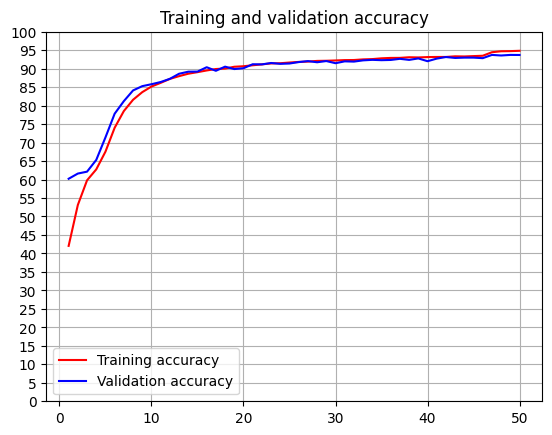

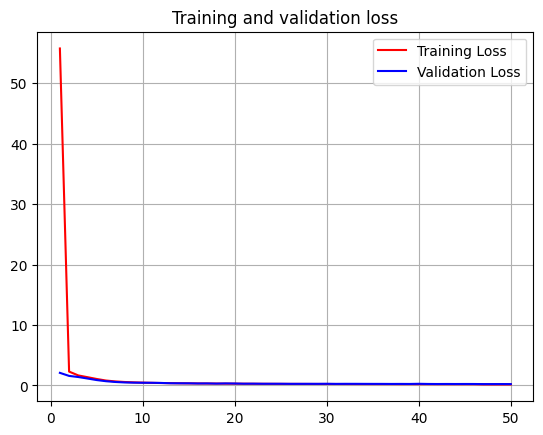

In [182]:
# Plot the learning curves
plot_learning_curves(train_accuracies, val_accuracies, train_losses, val_losses)